# Human Action Recognition using LRCN

In [1]:
#%%capture
!pip install tensorflow opencv-contrib-python pafy youtube-dl moviepy pydot

In [2]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# Step 1: Visualize the Data with its Labels

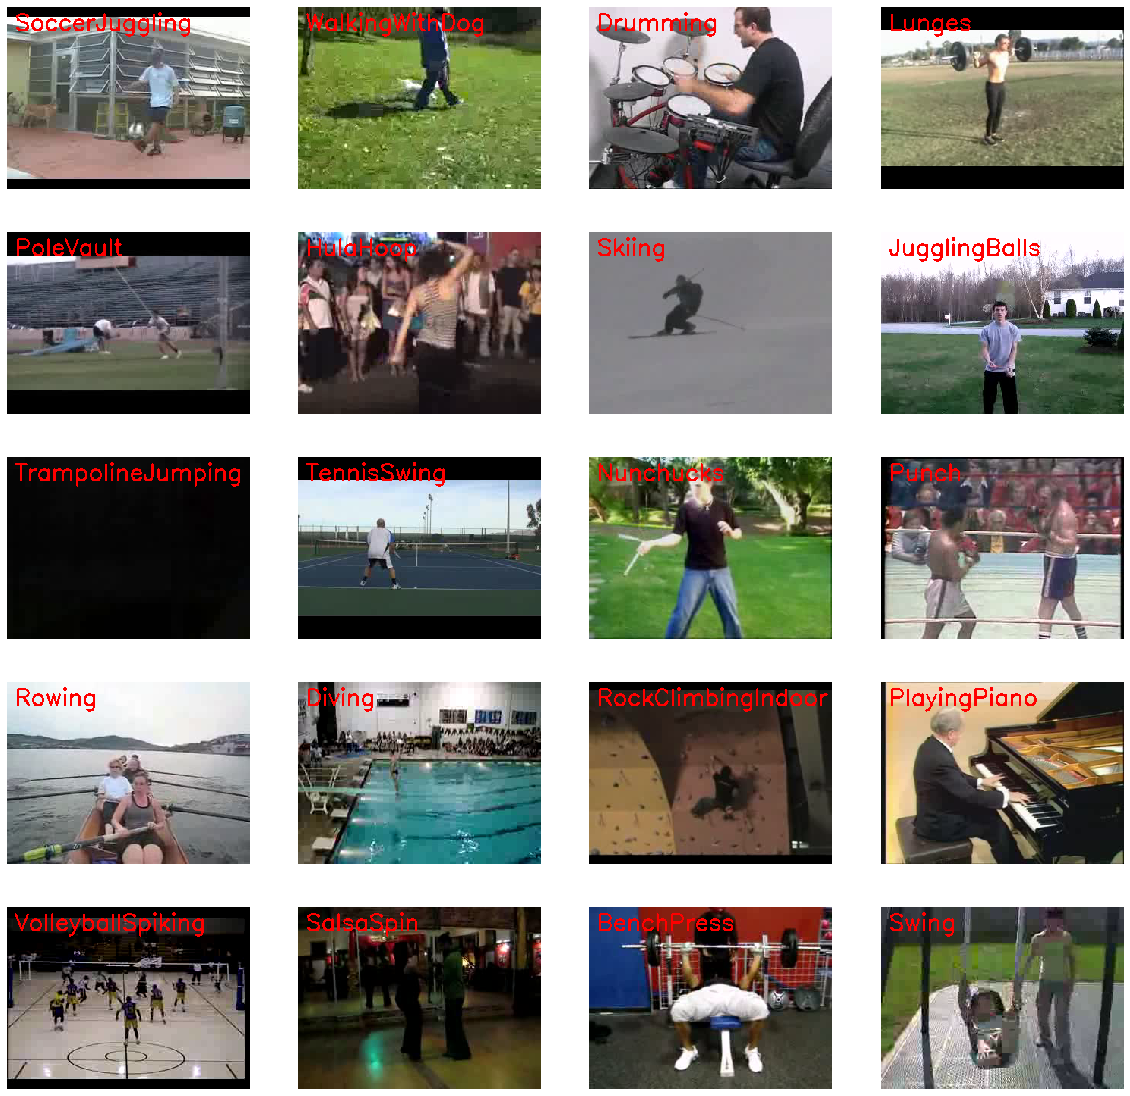

In [3]:
plt.figure(figsize = (20, 20))
all_classes_names = os.listdir('UCF50')
random_range = random.sample(range(len(all_classes_names)), 20)

for counter, random_index in enumerate(random_range, 1):
  selected_class_Name = all_classes_names[random_index]
  video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')
  selected_video_file_name = random.choice(video_files_names_list)
  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
  _, bgr_frame = video_reader.read()
  video_reader.release()
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
  cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
  plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

# Step 2: Preprocess the Dataset

In [4]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# The number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

DATASET_DIR = "dataset/UCF50"

# The list containing the names of the classes used for training.
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

## Create a Function to Extract, Resize & Normalize Frames

In [5]:
def frames_extraction(video_path):
    
  # This function will extract the required frames from a video after resizing and normalizing them.
    
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
      video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window) 
      success, frame = video_reader.read() 

      if not success:
          break

      resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
      
      # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
      normalized_frame = resized_frame / 255
      
      # Append the normalized frame into the frames list
      frames_list.append(normalized_frame)
    
    video_reader.release()
    return frames_list

## Create a Function for Dataset Creation

In [6]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
      print(f'Extracting Data of Class: {class_name}')
        
      # Get the list of video files present in the specific class name directory.
      files_list = os.listdir(os.path.join('UCF50', class_name))
      
      for file_name in files_list:
          video_file_path = os.path.join('UCF50', class_name, file_name)
          frames = frames_extraction(video_file_path)

          if len(frames) == SEQUENCE_LENGTH:

              # Append the data to their repective lists.
              features.append(frames)
              labels.append(class_index)
              video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)  
    
    return features, labels, video_files_paths

In [7]:
# Create the dataset
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


In [8]:
# Convert labels into one-hot encoded vectors
one_hot_encoded_labels = to_categorical(labels)

# Step 3: Split the Data into Train and Test Set

In [9]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.25, shuffle=True)

# Step 4: Implement the ConvLSTM Approch

## Step 4.1: Construct the model

In [10]:
def create_convlstm_model():

  model = Sequential()

  model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last", recurrent_dropout = 0.2,
                       return_sequences = True, input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  
  model.add(MaxPooling3D(pool_size = (1, 2, 2), padding = 'same', data_format = "channels_last"))
  model.add(TimeDistributed(Dropout(0.2)))


  model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last", recurrent_dropout = 0.2,
                       return_sequences = True))
  
  model.add(MaxPooling3D(pool_size = (1, 2, 2), padding = 'same', data_format = "channels_last"))
  model.add(TimeDistributed(Dropout(0.2)))


  model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last", recurrent_dropout = 0.2,
                       return_sequences = True))
  
  model.add(MaxPooling3D(pool_size = (1, 2, 2), padding = 'same', data_format = "channels_last"))
  model.add(TimeDistributed(Dropout(0.2)))


  model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last", recurrent_dropout = 0.2,
                       return_sequences = True))
  
  model.add(MaxPooling3D(pool_size = (1, 2, 2), padding = 'same', data_format = "channels_last"))
  # model.add(TimeDistributed(Dropout(0.2)))

  model.add(Flatten())

  model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

  model.summary()
  return model

In [11]:
# Construct the required convlstm model
convlstm_model = create_convlstm_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 20, 31, 31, 4)     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 31, 31, 4)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 20, 15, 15, 8)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 15, 15, 8)     0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 20, 13, 13, 14)    1

## Structure of the Constructed Model

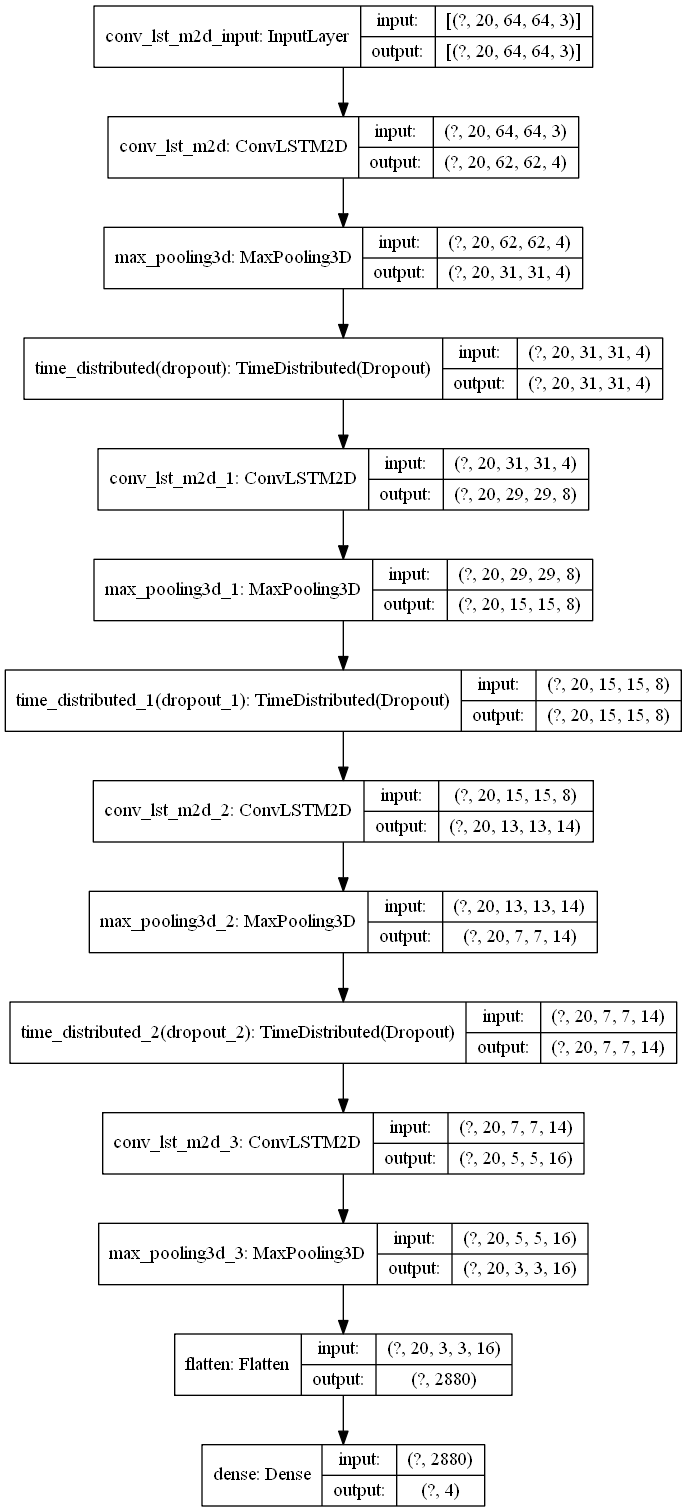

In [12]:
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

## Step 4.2: Compile & Train the Model

In [13]:
# Adding early stopping callback to prevent overfitting and start the training after compiling the model.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4, shuffle = True,
                                                     validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
73/73 [==============================] - 84s 1s/step - loss: 1.3954 - accuracy: 0.2432 - val_loss: 1.3641 - val_accuracy: 0.3014
Epoch 2/50
73/73 [==============================] - 83s 1s/step - loss: 1.3816 - accuracy: 0.2877 - val_loss: 1.3610 - val_accuracy: 0.3562
Epoch 3/50
73/73 [==============================] - 84s 1s/step - loss: 1.2608 - accuracy: 0.4692 - val_loss: 1.2377 - val_accuracy: 0.4658
Epoch 4/50
73/73 [==============================] - 83s 1s/step - loss: 1.1749 - accuracy: 0.4966 - val_loss: 0.9414 - val_accuracy: 0.6575
Epoch 5/50
73/73 [==============================] - 83s 1s/step - loss: 1.0587 - accuracy: 0.5137 - val_loss: 0.8943 - val_accuracy: 0.6986
Epoch 6/50
73/73 [==============================] - 83s 1s/step - loss: 0.8250 - accuracy: 0.6575 - val_loss: 0.7458 - val_accuracy: 0.6712
Epoch 7/50
73/73 [==============================] - 82s 1s/step - loss: 0.6834 - accuracy: 0.7226 - val_loss: 0.6861 - val_accuracy: 0.6986
Epoch 8/50
73/73 [==

In [14]:
# Evaluate the trained model
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

4/4 [==============================] - 4s 1s/step - loss: 0.4578 - accuracy: 0.8443


In [15]:
# Save the model
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'convlstm_model__Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

convlstm_model.save(model_file_name)

## Step 4.3: Plot Model's Loss & Accuracy Curves

In [16]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
  # Get metric values using metric names as identifiers.
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]
  
  # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
  epochs = range(len(metric_value_1))

  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  plt.title(str(plot_name))
  plt.legend()

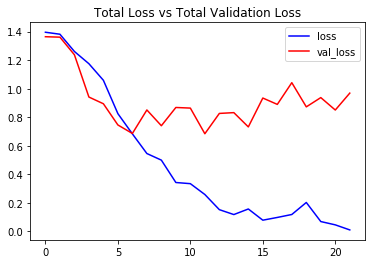

In [17]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

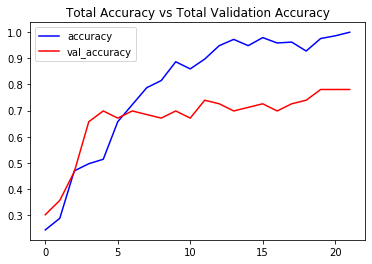

In [18]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Step 5: Implement the LRCN Approach

In [19]:
def create_LRCN_model():
  model = Sequential()
    
  model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                            input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  
  model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
  model.add(TimeDistributed(Dropout(0.25)))
  

  model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  model.add(TimeDistributed(Dropout(0.25)))
  

  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  model.add(TimeDistributed(Dropout(0.25)))
  

  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  #model.add(TimeDistributed(Dropout(0.25)))
                                    
  model.add(TimeDistributed(Flatten()))
                                    
  model.add(LSTM(32))
                                    
  model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

  model.summary()
  
  return model

In [20]:
# Construct the LRCN model
LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 20, 64, 64, 16)    448       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 16, 16, 32)    4640      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 20, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 20, 4, 4, 64)     

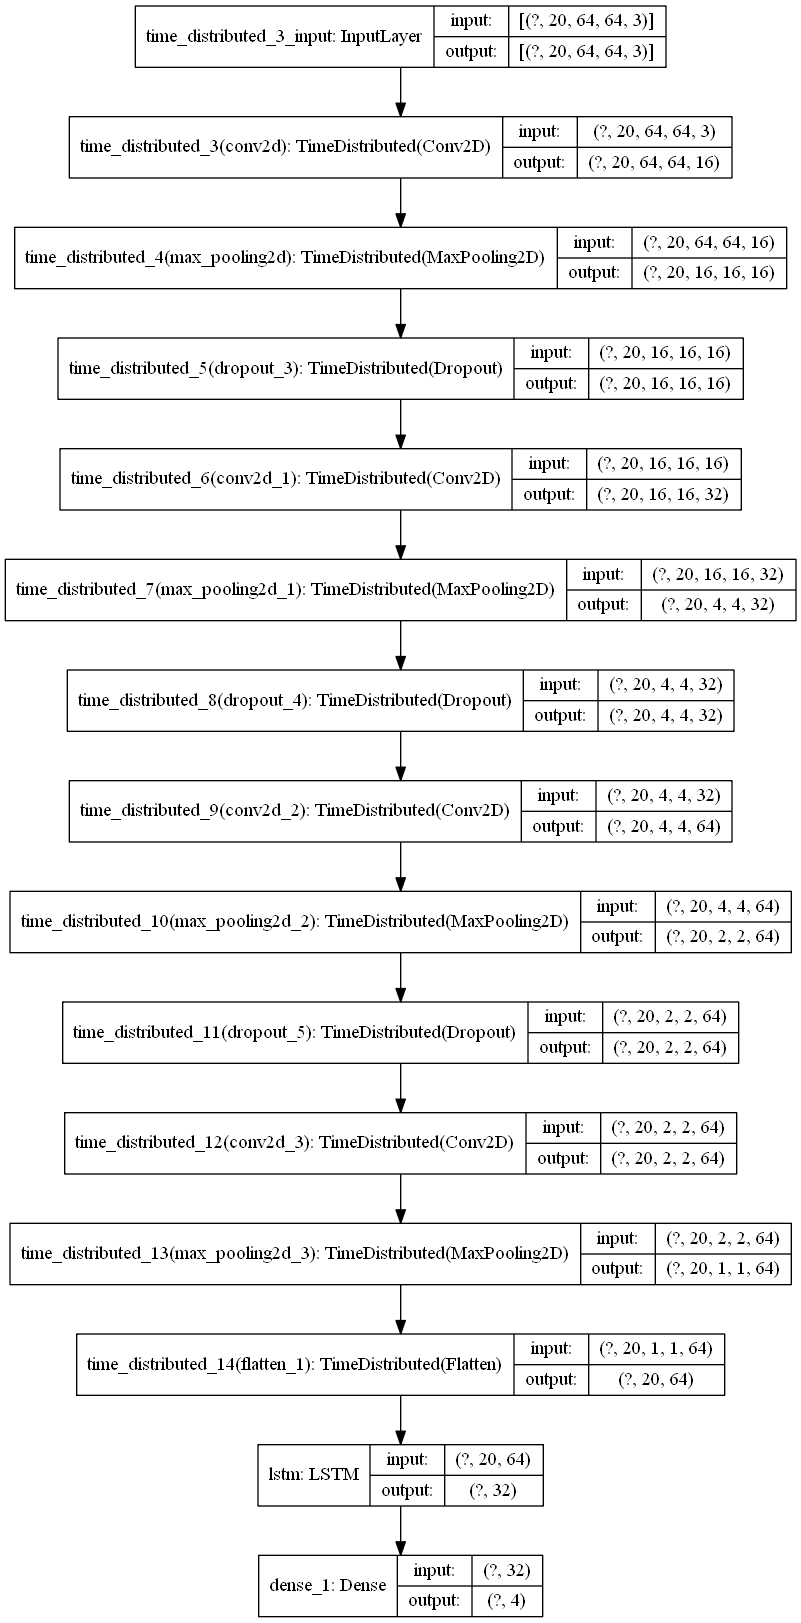

In [21]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

## Step 5.2: Compile & Train the Model

In [22]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
73/73 [==============================] - 7s 90ms/step - loss: 1.3903 - accuracy: 0.2432 - val_loss: 1.3331 - val_accuracy: 0.3151
Epoch 2/50
73/73 [==============================] - 6s 84ms/step - loss: 1.2990 - accuracy: 0.4178 - val_loss: 1.2525 - val_accuracy: 0.3973
Epoch 3/50
73/73 [==============================] - 6s 82ms/step - loss: 1.1381 - accuracy: 0.5137 - val_loss: 0.9587 - val_accuracy: 0.6027
Epoch 4/50
73/73 [==============================] - 6s 80ms/step - loss: 1.0773 - accuracy: 0.5274 - val_loss: 1.0288 - val_accuracy: 0.5342
Epoch 5/50
73/73 [==============================] - 6s 80ms/step - loss: 0.9694 - accuracy: 0.5890 - val_loss: 0.8903 - val_accuracy: 0.6575
Epoch 6/50
73/73 [==============================] - 6s 80ms/step - loss: 0.8101 - accuracy: 0.6781 - val_loss: 0.7250 - val_accuracy: 0.7397
Epoch 7/50
73/73 [==============================] - 6s 81ms/step - loss: 0.7260 - accuracy: 0.7123 - val_loss: 0.6808 - val_accuracy: 0.7397
Epoch 8/50
73

In [23]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 [==============================] - 1s 150ms/step - loss: 0.3521 - accuracy: 0.8770


In [24]:
# Save the Model
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

## Step 5.3: Plot Model’s Loss & Accuracy Curves

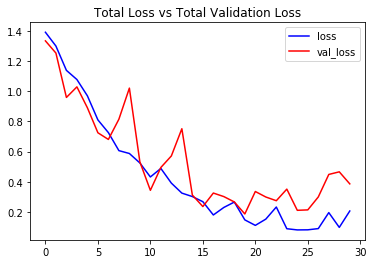

In [25]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

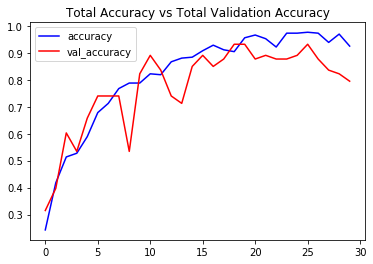

In [26]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Step 6: Test the Best Performing Model on YouTube videos

From the results, it seems that the LRCN model performed significantly well for a small number of classes. so in this step, we will put the LRCN model to test on some youtube videos.

### Create a function to download YouTube Videos:

In [27]:
def download_youtube_videos(youtube_video_url, output_directory):
    video = pafy.new(youtube_video_url)
    title = video.title
    video_best = video.getbest()
    output_file_path = f'{output_directory}/{title}.mp4'
    video_best.download(filepath = output_file_path, quiet = True)
    return title

### Download a Test Video

In [28]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_videos_directory)

input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

### Create a Function To Perform Action Recognition on Videos

In [29]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
  video_reader = cv2.VideoCapture(video_file_path)

  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                  video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

  frames_queue = deque(maxlen = SEQUENCE_LENGTH)

  predicted_class_name = ''

  while video_reader.isOpened():
    ok, frame = video_reader.read() 
    if not ok:
        break

    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    normalized_frame = resized_frame / 255

    frames_queue.append(normalized_frame)

    if len(frames_queue) == SEQUENCE_LENGTH:
        predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

        predicted_label = np.argmax(predicted_labels_probabilities)

        predicted_class_name = CLASSES_LIST[predicted_label]

    
    cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    video_writer.write(frame)
   
  video_reader.release()
  video_writer.release()

In [30]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

t:   0%|▏                                                                    | 3/867 [00:00<00:32, 26.82it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
